## Part 1 : Data Preprocessing and Input Pipeline

In [88]:
%pwd

'/Users/theojanson/Developer/School/polytechnique/INF642-Socio-Emotional-Conversational-Agents/Lab2'

In [89]:
import pickle
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split

from src.data_utils import *

Question 1: Plot the distribution of each feature in the training set. Comment and explain the results.

In [2]:
data = {}
_dir = "dataset/"
for file in os.listdir(_dir):
    name = file[:-4]
    data[name] = load_pickle(_dir+file)


In [3]:
data["AU01"].shape

(613, 50)

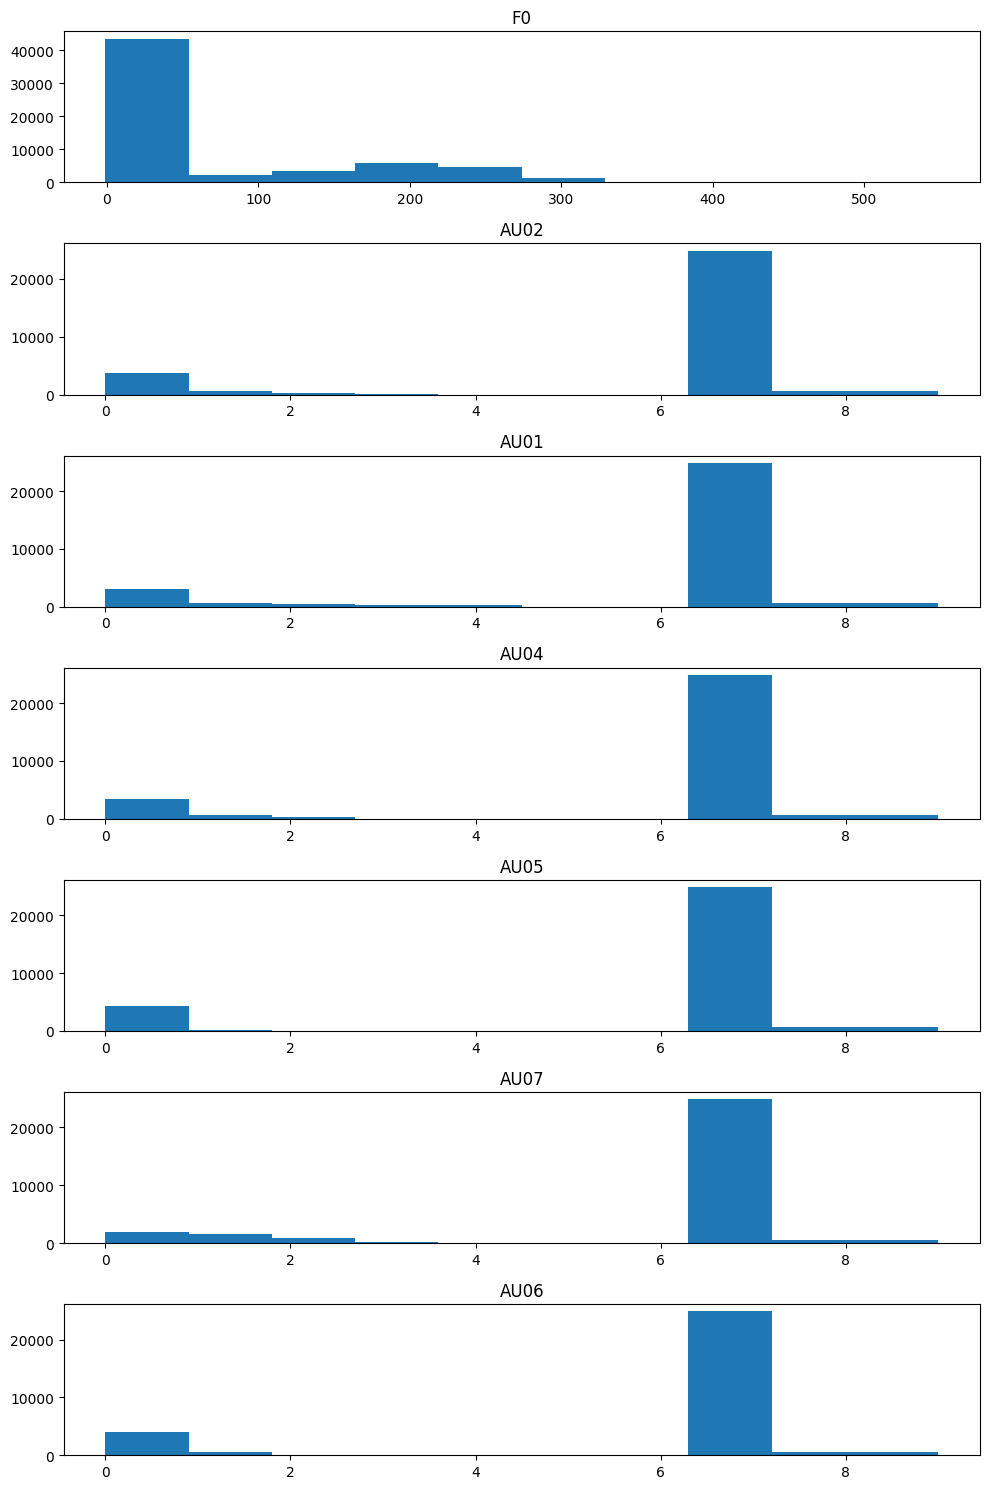

In [4]:

fig, axs=plt.subplots(7,1, figsize=(10,15))
for i, (feature, array) in enumerate(data.items()):
    axs[i].set_title(feature)
    array = array.flatten()
    axs[i].hist(array)
plt.tight_layout()
plt.show()


Question 2: Perform data clipping for each of your features, with a range that corresponds best to each feature’s distribution.

In [ ]:
def clip():
    pass

Question 3: Perform uniform quantization on each feature data, using a quantization bit equal to 5

In [5]:
def quantize_uniform(x, quant_min=0.0, quant_max=1.0, quant_level=5):
    """https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2S2_DigitalSignalQuantization.html"""
    """Uniform quantization approach

    Notebook: C2/C2S2_DigitalSignalQuantization.ipynb

    Args:
        x (np.ndarray): Original signal
        quant_min (float): Minimum quantization level (Default value = -1.0)
        quant_max (float): Maximum quantization level (Default value = 1.0)
        quant_level (int): Number of quantization levels (Default value = 5)

    Returns:
        x_quant (np.ndarray): Quantized signal
    """
    x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize > quant_level - 1] = quant_level - 1
    x_normalize[x_normalize < 0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant

In [6]:
for name, array in data.items():
    data[name] = quantize_uniform(array,
                                    quant_min=np.min(array), 
                                    quant_max=np.max(array))

Question 4: Normalize your data between 0 and 1.

In [7]:
for name, array in data.items():
    data[name] = preprocessing.minmax_scale(array,
                                            feature_range=(0, 1))

Question 5: Split your data into 3 sets: training set (80%), validation set (10%), and a testing
set (10%).

In [8]:
assert len(set([len(v) for v in data.values()])) == 1

indices = np.array([x for x in range(len(data["F0"]))])

train_idx, test_idx = train_test_split(indices, test_size=0.1)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1)

print(len(train_idx) / len(indices))
print(len(val_idx) / len(indices))
print(len(test_idx) / len(indices))


0.8075040783034257
0.09135399673735727
0.10114192495921696


Question 6: In this part, you need to convert the quantized and normalized sequences of values for each feature, into sequences of token IDs (Integer Encoding), which will be used later as indices into an embedding.
To perform integer encoding on AUs:
- Create a dictionary “ID_to_AU” for each AU storing the quantized and normalized AU unique values that you got in Question 4. Each value is mapped to an ID (key). The dictionary should include the start token 8.0, the end token 9.0, as well as the padding token 7.0. Note that paddings should be placed at key = 0.
o Example: ID_to_AU: {0: 7.0, 1: 8.0, 2: 9.0, 3: 0.0, 4: 0.1, 5: 0.2, 6: 0.3, 7: 0.4, ... , 55:5.0}
- Create a dictionary “AU_to_ID” : in this case, AU values will be the keys of your
dictionaries, and the “IDs” will be stored as the values of the dictionary. This could
simply be performed using the following command: AU_to_ID = {v:k for k, v in ID_to_AU.items()}.
- Integer Encode your AU values using “AU_to_ID” dictionary
- Keep the dictionary “ID_to_AU” aside as it will be used to convert the tokens back to
their corresponding AU values.

In [43]:
unique_vals = [list(np.unique(array)) for array in data.values()]
unique_vals = set([item for sublist in unique_vals for item in sublist])


ID_to_AU_special = {0: 7.0, 
                    1: 8.0, 
                    2: 9.0}
idx = range(len(ID_to_AU_special),len(unique_vals)+len(ID_to_AU_special))
ID_to_AU = {k:v for k,v in zip(idx, unique_vals)}
ID_to_AU.update(ID_to_AU_special)

AU_to_ID=  {v:k for k,v in ID_to_AU.items()}

In [44]:
AU_to_ID

{0.0: 3,
 0.25: 4,
 0.6666666666666666: 5,
 0.33333333333333337: 6,
 0.5: 7,
 0.75: 8,
 1.0: 9,
 0.3333333333333333: 10,
 7.0: 0,
 8.0: 1,
 9.0: 2}

In [47]:
def encode_sequence(array):
    encoded_sequence = np.zeros_like(array)
    for i in range(len(array)):
        encoded_sequence[i] = AU_to_ID[array[i]]
    return encoded_sequence

def encode(array, max_size=55): 
    encoded_array = np.zeros((array.shape[0], max_size+2)) #add two to max size for start and end token
    for i, sequence in enumerate(array): 
        encoded_array[i][0] = AU_to_ID[7.0] #start token
        encoded_array[i][1:sequence.shape[0]+1] = encode_sequence(sequence)
        encoded_array[i][sequence.shape[0]+1] = AU_to_ID[8.0] #start token
        encoded_array[i][sequence.shape[0]+2] = AU_to_ID[9.0] #padding tokens
    return encoded_array


encoded_data = {}
for name, array in data.items():
    encoded_data[name] = encode(array, max_size=102)


Question 7: Use utils.py to create a train, val and test dataset

In [86]:
os.makedirs("encoded_dataset", exist_ok=True) 

for name, array in encoded_data.items(): 
    np.random.shuffle(array)   
    train_data = array[train_idx]
    val_data = array[val_idx]
    test_data = array[test_idx]
    save_pickle(train_data, f"encoded_dataset/{name}_train.pkl")
    save_pickle(val_data, f"encoded_dataset/{name}_val.pkl")
    save_pickle(test_data, f"encoded_dataset/{name}_test.pkl")

